# 0 Import Statements

In [1]:
#!pip install opencv-python
#!pip install scikit-learn
#!pip install imblearn
#!pip install tensorflow
#!pip install seaborn

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

np.random.seed(1000)

# 1 Preprocessing

## 1.1 Read-in data

In [2]:
# read in data that assigns each image path a label
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [3]:
# value counts of each label in the dataset
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

## 1.2 Shuffle the dataframe and split it into X (image paths) and y (labels)

In [4]:
# shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df_shuffled.head(5))
# split data into features (X) and labels (y)
X = df_shuffled["image"]
y = df_shuffled["label"]

                          image  label
0  ESP_027475_2310_RED-0112.jpg      0
1  ESP_034557_1510_RED-0201.jpg      0
2  PSP_002455_1320_RED-0111.jpg      2
3  PSP_010587_1620_RED-0342.jpg      0
4  ESP_033955_2065_RED-0059.jpg      0


## 1.3 Train-Test-Split

In [5]:
# splitting the data into train and test sets
Xp_train_before, Xp_test, yp_train_before, yp_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(Xp_train_before.shape, yp_train_before.shape, "Train")
print(Xp_test.shape, yp_test.shape, "Test")

(6489,) (6489,) Train
(4326,) (4326,) Test


In [6]:
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]


## 1.4 Filter 4.5k images from the train set

In [7]:
# filter 4.5k images from the train set and corresponding labels
index = Xp_train_before[yp_train_before == 0].sample(n=4500, random_state=42).index
Xp_train = Xp_train_before.drop(index)
yp_train = yp_train_before.drop(index)

print(Xp_train.shape, yp_train.shape)
print("Distribution of labels in the train set")
print(np.unique(yp_train, return_counts=True))
print(np.around(np.unique(yp_train, return_counts=True)[1]/yp_train.shape[0], decimals=4))

(1989,) (1989,)
Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]


## 1.5 Read-in images and normalize

In [8]:
# helper function that normalizes an input image
def normalize_image(image):
    image = image/255.0
    return image

# load the images from the path in the array and store them as pixels in an array
def load_images(X, y, folder):
    images = []
    labels = []
    for index in X.index:
        image = cv2.imread(folder+"/"+X[index], cv2.IMREAD_GRAYSCALE)
        image = normalize_image(image)
        if images is not None:
            images.append(image)
            labels.append(y[index])
    return np.array(images), np.array(labels)

In [9]:
# load the images from the train, test, and validation set
X_train, y_train = load_images(Xp_train, yp_train, "map-proj-v3_2")
X_test, y_test = load_images(Xp_test, yp_test, "map-proj-v3_2")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1989, 227, 227) (1989,)
(4326, 227, 227) (4326,)


In [10]:
print("Distribution of labels in the train set before filtering 5.4k images")
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))
print("\nDistribution of labels in the train set")
print(np.unique(y_train, return_counts=True))
print(np.around(np.unique(y_train, return_counts=True)[1]/y_train.shape[0], decimals=4))
print("\nDistribution of labels in the test set")
print(np.unique(y_test, return_counts=True))
print(np.around(np.unique(y_test, return_counts=True)[1]/y_test.shape[0], decimals=4))

Distribution of labels in the train set before filtering 5.4k images
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]

Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]

Distribution of labels in the test set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([3562,  315,   64,   86,   98,   27,  117,   57]))
[0.8234 0.0728 0.0148 0.0199 0.0227 0.0062 0.027  0.0132]


## 1.6 Imbalance handling

### 1.6.0 Flatten images

In [11]:
# faltten the images to feed them to the ADASYN and random oversampling algorithm
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(1989, 227, 227)
(1989, 51529)


### 1.6.1 ADASYN

In [12]:
# apply ADASYN oversampling algorithm to the train set
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

### 1.6.2 Oversampling

In [13]:
# apply random oversampling algorithm to the train set
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [14]:
# double check that the oversampling worked - first label and all labels
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 261
Number of duplicates for all labels after oversampling: 3931


### 1.6.3 Overview of datasets

In [15]:
# comparing the three datasets used for training: original, ADASYN, and random oversampling
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

[0 1 2 3 4 5 6 7] [740 479 102 181 152  47 181 107]
[0 1 2 3 4 5 6 7] [740 701 730 729 748 736 767 740]
[0 1 2 3 4 5 6 7] [740 740 740 740 740 740 740 740]


In [16]:
# reshahping the images back to original form of 227x227
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training original training instances: \n{X_train.shape}, correspoding y: {y_train.shape}")
print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training original training instances: 
(1989, 227, 227), correspoding y: (1989,)
Shape of training instances generated by ADASYN: 
(5891, 227, 227), correspoding y: (5891,)
Shape of training instances generated by RandomOverSampler: 
(5920, 227, 227), correspoding y: (5920,)


## 1.7 Augmentation
Rotate 90, 180, 270, Flip Horizontally, Flip Vertically, Zoom (1.2)

In [17]:
# helper function used to create zoomed images
def zoom_at(img, zoom):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

# augmenting the images in 6 different ways and adding them to the training set
def augment_images(images, labels):

    # Empty numpy array to store the augmented images and return once all images have been augmented
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    
    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        #print(f"Image, {i} done")

    return augmented_images, augmented_labels

## 1.7.1 Augmenting a sample of 1000 images for SVM training

In [18]:
# choose 1000 random images from the ADASYN and random oversampling datasets and augment them
index = np.random.choice(X_t_A.shape[0], 1000, replace=False)
X_t_A_A, y_t_A_A = augment_images(X_t_A[index], y_t_A[index]) # ADASYN
X_t_O_A, y_t_O_A = augment_images(X_t_O[index], y_t_O[index]) # Random Oversampling
index = np.random.choice(X_train.shape[0], 1000, replace=False)
X_train_sample, y_train_sample = augment_images(X_train[index], y_train[index]) # Original

In [19]:
print(f"Shape of augmented sample for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of augmented sample for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")
print(f"Shape of augmented sample of original data: {X_train_sample.shape} with corresponding y: {y_train_sample.shape}")

Shape of augmented sample for ADASYN: (7000, 227, 227) with corresponding y: (7000,)
Shape of augmented sample for RandomOverSampler: (7000, 227, 227) with corresponding y: (7000,)
Shape of augmented sample of original data: (7000, 227, 227) with corresponding y: (7000,)


## 1.8 Displaying random images and their augmentations

In [20]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# choosing random images from the training data that are originals (divisible by 7)
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# plotting the original images and their augmentations (following 6 images)
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 5))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

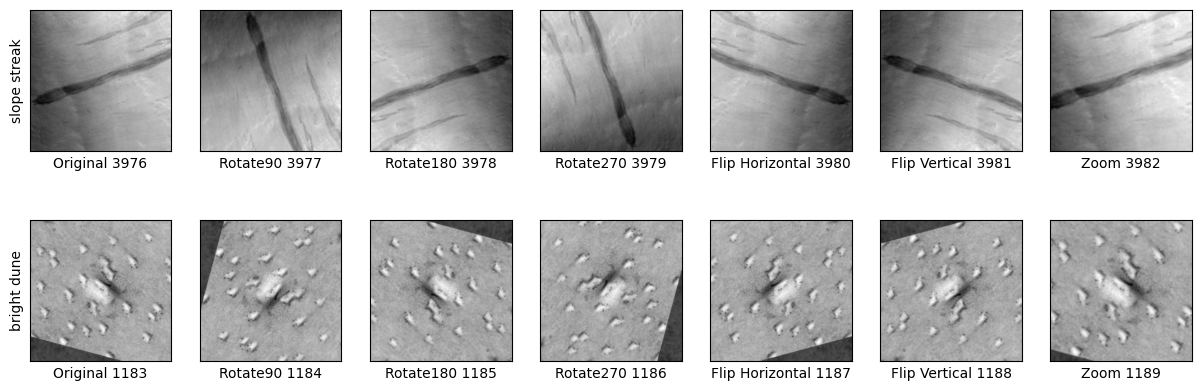

In [21]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 2)

# 2 Train SVM with different datasets

In [22]:
def shuffle_data(x, y):
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]

## 2.1 SVM ADASYN (on sample of 1000)
Create and SVM classifier training using grid search on a sample of 1000 images of the whole training set created by ADASYN
- these 1000 images were augmented such that the data used for training are 7000 images

In [23]:
# define and shuffle dataset
X_model, y_model = shuffle_data(X_t_A_A, y_t_A_A)

X_model = X_model.flatten().reshape(X_t_A_A.shape[0], 51529)
X_test_flat = X_test.flatten().reshape(X_test.shape[0], 51529)

In [24]:
# define the parameter grid for grid search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.1, 1, "scale"]
}

# create an SVM classifier
svm = SVC()

# grid search with 3 cross-validations
grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2)
grid_search.fit(X_model, y_model)

# best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.8s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  25.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  32.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  33.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  33.4s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  22.7s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  23.3s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  24.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  25.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  23.5s
[CV] END ......................C=0.1, gamma=1, k

In [38]:
# evaluate the model on the test set
test_score = grid_search.score(X_test_flat, y_test)
print("Test Score: ", test_score)

Test Score:  0.1754507628294036


## 2.2 SVM Random Oversampling (on sample of 1000)
Create and SVM classifier training using grid search on a sample of 1000 images of the whole training set created by Random Oversampling
- these 1000 images were augmented such that the data used for training are 7000 images

In [41]:
# define and shuffle dataset
X_model, y_model = shuffle_data(X_t_O_A, y_t_O_A)

X_model = X_model.flatten().reshape(X_t_A_A.shape[0], 51529)
X_test_flat = X_test.flatten().reshape(X_test.shape[0], 51529)

In [42]:
# define the parameter grid for grid search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.1, 1, "scale"]
}

# create an SVM classifier
svm = SVC()

# grid search with 3 cross-validations
grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2)
grid_search.fit(X_model, y_model)

# best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  24.9s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  25.7s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  27.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  35.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  31.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  32.4s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  25.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  24.9s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  26.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  26.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  26.5s
[CV] END ......................C=0.1, gamma=1, k

In [43]:
# evaluate the model on the test set
test_score = grid_search.score(X_test_flat, y_test)
print("Test Score: ", test_score)

Test Score:  0.1807674526121128


## 2.3 SVM Imbalanced (on sample of 1000)
Create and SVM classifier training using grid search on a sample of 1000 images of the original training set
- these 1000 images are augmented such that the data used for training are 7000 images

In [48]:
# define and shuffle dataset
X_model, y_model = shuffle_data(X_train_sample, y_train_sample)

X_model = X_model.flatten().reshape(X_t_A_A.shape[0], 51529)
X_test_flat = X_test.flatten().reshape(X_test.shape[0], 51529)

In [49]:
# define the parameter grid for grid search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.1, 1, "scale"]
}

# create an SVM classifier
svm = SVC()

# grid search with 3 cross-validations
grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2)
grid_search.fit(X_model, y_model)

# best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  26.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  26.8s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  26.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  26.7s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  26.4s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  24.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  28.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  29.3s
[CV] END ......................C=0.1, gamma=1, k

In [50]:
# evaluate the model on the test set
test_score = grid_search.score(X_test_flat, y_test)
print("Test Score: ", test_score)

Test Score:  0.6171983356449375
